<a href="https://colab.research.google.com/github/SaurabhManral/Acquisition-Scorecard-development-for-Auto-Loans/blob/main/Acquisition_scorecard_development_for%20AutoLoans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import gc
import json
import pickle
import warnings
import datetime as dt
from datetime import datetime
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import pyspark.pandas as ps
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pandas.tseries.offsets import MonthEnd, MonthBegin, DateOffset

from pyspark.sql import functions as F
from pyspark.sql.functions import (
    when, isnan, isnull, col, date_format, month, count, to_date, lit,
    regexp_replace, upper, coalesce, dayofmonth, datediff, udf,
    to_timestamp, months_between, create_map
)
from pyspark.sql.functions import round as pround
from pyspark.sql.types import StringType, IntegerType

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    confusion_matrix, roc_curve
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb

from tqdm import tqdm
from itertools import chain

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/pyspark/pandas/__init__.py:43: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## Reading data

In [ ]:
dic=pd.read_csv("/content/gdrive/MyDrive/Grab/data_dictionary.csv")

In [ ]:
data=pd.read_csv("/content/gdrive/MyDrive/Grab/train.csv")

## EDA

In [ ]:
#Managing data types and creating 'yearmonth' column
data['DisbursalDate'] = pd.to_datetime(data['DisbursalDate'])
data['Date.of.Birth'] = pd.to_datetime(data['Date.of.Birth'], dayfirst=True, errors="coerce")

mask = data["Date.of.Birth"] > data["DisbursalDate"]
data.loc[mask, "Date.of.Birth"] = (data.loc[mask, "Date.of.Birth"] - pd.DateOffset(years=100))

data['yearmonth'] = data['DisbursalDate'].dt.strftime('%Y-%m')

In [ ]:
#Checking value counts for data distribution
month_counts = data['yearmonth'].value_counts().sort_index()
month_cumulative_counts = month_counts.cumsum()
month_percent_counts = (month_counts / month_counts.sum()) * 100

summary_df = pd.DataFrame({
    'count': month_counts,
    'cumulative_count': month_cumulative_counts,
    'percentage': month_percent_counts,
    'cumulative_percentage': month_percent_counts.cumsum()})

print(summary_df)

           count  cumulative_count  percentage  cumulative_percentage
yearmonth                                                            
2018-01     1708              1708    0.732563               0.732563
2018-02       25              1733    0.010723               0.743286
2018-03     5148              6881    2.207983               2.951268
2018-04     4627             11508    1.984525               4.935794
2018-05     2890             14398    1.239524               6.175318
2018-06     5991             20389    2.569546               8.744864
2018-07     4150             24539    1.779939              10.524803
2018-08    56975             81514   24.436638              34.961442
2018-09    54443            135957   23.350661              58.312103
2018-10    84875            220832   36.402978              94.715081
2018-11     6709            227541    2.877497              97.592578
2018-12     5613            233154    2.407422             100.000000


,yearmonth,count,event,event%
0,2018-01,1708,392,0.229508
1,2018-02,25,2,0.080000
2,2018-03,5148,1054,0.204740
3,2018-04,4627,991,0.214178
4,2018-05,2890,611,0.211419
5,2018-06,5991,1294,0.215991
6,2018-07,4150,928,0.223614
7,2018-08,56975,12037,0.211268
8,2018-09,54443,10533,0.193468
9,2018-10,84875,20401,0.240365


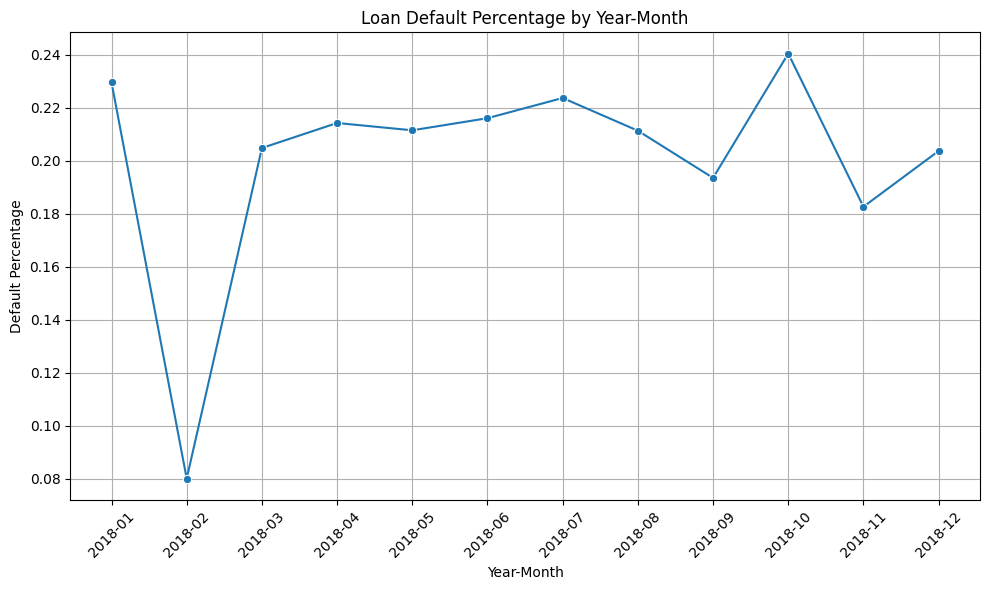

In [ ]:
#printing the target distribution

def summary(df):
  AA = df.groupby('yearmonth').agg(count=('UniqueID','count'), event=('loan_default','sum')).reset_index()
  AA['event%'] = AA['event']/AA['count']
  display(AA)

  plt.figure(figsize=(10, 6))
  sns.lineplot(data=AA, x='yearmonth', y='event%', marker='o')
  plt.title('Loan Default Percentage by Year-Month')
  plt.xlabel('Year-Month')
  plt.ylabel('Default Percentage')
  plt.grid(True)
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

summary(data)

In [ ]:
#Removing the anomaly month feb'18 from data
data = data[data['yearmonth'] != '2018-02']

## Feature engineering

In [ ]:

#Calculating age and age bucket (demog)
data["age_at_disbursal"] = np.ceil((data["DisbursalDate"] - data["Date.of.Birth"]).dt.days / 365.25)

data["age_bucket"] = pd.cut(data["age_at_disbursal"],bins=[0, 23, 30, 40, 60, 100],labels=["<23", "23-30", "30-40", "40-60", "60+"])
data["very_young_flag"] = (data["age_at_disbursal"] < 23).astype(int)
data["senior_flag"] = (data["age_at_disbursal"] > 50).astype(int)

#Creating interaction features
data["self_employed_flag"] = (data["Employment.Type"] == "Self employed").astype(int)
data["young_self_employed_flag"] = ((data["self_employed_flag"] == 1) & (data["age_at_disbursal"] < 30)).astype(int)

#Actual LTV (asset risk)
data["actual_ltv"] = data["disbursed_amount"] / data["asset_cost"]

data["high_ltv_flag"] = (data["actual_ltv"] > 0.85).astype(int)
data["very_high_ltv_flag"] = (data["actual_ltv"] > 0.90).astype(int)

#Calculating total EMI to loan ratio (early stress)
data["PRIMARY.INSTAL.AMT"] = data["PRIMARY.INSTAL.AMT"].fillna(0)
data["SEC.INSTAL.AMT"] = data["SEC.INSTAL.AMT"].fillna(0)

data["total_monthly_emi"] = (data["PRIMARY.INSTAL.AMT"] + data["SEC.INSTAL.AMT"])

data["emi_to_loan_ratio"] = (data["total_monthly_emi"] / data["disbursed_amount"])


#Converting Average acct age and Credit history from text to numerical months
def convert_yrs_mon_to_months(value):
    if pd.isna(value):
        return pd.NA
        value = str(value).lower().strip()
    yrs_match = re.search(r'(\d+)\s*yrs?', value)
    mon_match = re.search(r'(\d+)\s*mon', value)
    years = int(yrs_match.group(1)) if yrs_match else 0
    months = int(mon_match.group(1)) if mon_match else 0
    return years * 12 + months

data["avg_account_age_months"] = data["AVERAGE.ACCT.AGE"].apply(convert_yrs_mon_to_months)
data["credit_history_months"] = data["CREDIT.HISTORY.LENGTH"].apply(convert_yrs_mon_to_months)

data[["avg_account_age_months", "credit_history_months"]] = data[["avg_account_age_months", "credit_history_months"]].fillna(0)


#Creating Bureau features
data["bureau_thin_flag"] = (data["credit_history_months"] < 12).astype(int)
data["bureau_very_thin_flag"] = (data["credit_history_months"] < 6).astype(int)

data["total_accounts"] = (data["PRI.NO.OF.ACCTS"] + data["SEC.NO.OF.ACCTS"])
data["sec_ratio"] = np.where(data["total_accounts"] > 0,data["SEC.NO.OF.ACCTS"]/data["total_accounts"],0)

data["total_sanctioned_amt"] = (data["PRI.SANCTIONED.AMOUNT"] + data["SEC.SANCTIONED.AMOUNT"])
data["total_current_balance"] = (data["PRI.CURRENT.BALANCE"] + data["SEC.CURRENT.BALANCE"])

data["utilization_ratio"] = np.where(data["total_sanctioned_amt"] > 0,data["total_current_balance"] / data["total_sanctioned_amt"],0)

data["credit_velocity"] = (data["NEW.ACCTS.IN.LAST.SIX.MONTHS"] + data["NO.OF_INQUIRIES"])
data["credit_hungry_flag"] = (data["credit_velocity"] >= 3).astype(int)

data["enquiry_conversion_ratio"] = np.where(data["NO.OF_INQUIRIES"] > 0,data["NEW.ACCTS.IN.LAST.SIX.MONTHS"] / data["NO.OF_INQUIRIES"],0)
data["enquiry_conversion_ratio"] = data["enquiry_conversion_ratio"].clip(0, 2)

data["no_hit_flag"] = (data["PERFORM_CNS.SCORE"] <= 0).astype(int)
data["low_score_flag"] = (data["PERFORM_CNS.SCORE"] < 650).astype(int)

data['pri_active_ratio'] = np.where(data['PRI.NO.OF.ACCTS'] > 0, data['PRI.ACTIVE.ACCTS'] / data['PRI.NO.OF.ACCTS'], 0)
data['pri_overdue_ratio'] = np.where(data['PRI.NO.OF.ACCTS'] > 0, data['PRI.OVERDUE.ACCTS'] / data['PRI.NO.OF.ACCTS'], 0)
data['total_overdue_accts'] = data['PRI.OVERDUE.ACCTS'] + data['SEC.OVERDUE.ACCTS']

def categorize_cns_score(score):
    if score <= 0:
        return 'No score'
    elif 0 < score <= 500:
        return 'Low score'
    elif 500 < score <= 700:
        return 'Medium score'
    elif 700 < score <= 800:
        return 'High score'
    else:
        return 'Very high score'

data['cns_score_category'] = data['PERFORM_CNS.SCORE'].apply(categorize_cns_score)


#Calculating miscelleneous features
data['disbursed_to_sanctioned_ratio'] = np.where(data['total_sanctioned_amt'] > 0,data['disbursed_amount'] / data['total_sanctioned_amt'],0)

data['inquiry_per_total_accts'] = np.where(data['total_accounts'] > 0,data['NO.OF_INQUIRIES'] / data['total_accounts'],0)

data['sec_acct_flag'] = (data['SEC.NO.OF.ACCTS'] > 0).astype(int)
data['overdue_acct_flag'] = (data['total_overdue_accts'] > 0).astype(int)

In [ ]:
#Treating ID columns with low cardinality and making them categorical
data['branch_id']='branch_'+data['branch_id'].astype(str)
data['manufacturer_id']='manufacturer_'+data['manufacturer_id'].astype(str)
data['state_id']='state_'+data['State_ID'].astype(str)

In [ ]:
feature_list=['UniqueID', 'disbursed_amount', 'asset_cost',  'branch_id',
 'manufacturer_id','MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
        'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'NO.OF_INQUIRIES','loan_default', 'yearmonth',  'age_bucket',
       'very_young_flag', 'senior_flag', 'self_employed_flag',
       'young_self_employed_flag', 'actual_ltv', 'high_ltv_flag',
       'very_high_ltv_flag', 'total_monthly_emi', 'emi_to_loan_ratio',
       'avg_account_age_months', 'credit_history_months', 'bureau_thin_flag',
       'bureau_very_thin_flag', 'total_accounts', 'sec_ratio',
       'total_sanctioned_amt', 'total_current_balance', 'utilization_ratio',
       'credit_velocity', 'credit_hungry_flag', 'enquiry_conversion_ratio',
       'no_hit_flag', 'low_score_flag', 'state_id',
       'pri_active_ratio', 'pri_overdue_ratio', 'total_overdue_accts',
       'cns_score_category', 'disbursed_to_sanctioned_ratio',
       'inquiry_per_total_accts', 'sec_acct_flag', 'overdue_acct_flag']

feature_drop_list=['supplier_id','ltv','Current_pincode_ID','Date.of.Birth',
                   'Employment.Type','DisbursalDate','State_ID',
                   'Employee_code_ID','PERFORM_CNS.SCORE.DESCRIPTION',
                   'AVERAGE.ACCT.AGE','CREDIT.HISTORY.LENGTH','age_at_disbursal']

data=data[feature_list]
pd.set_option('display.max_columns', None)
data.head()

,UniqueID,disbursed_amount,asset_cost,branch_id,manufacturer_id,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default,yearmonth,age_bucket,very_young_flag,senior_flag,self_employed_flag,young_self_employed_flag,actual_ltv,high_ltv_flag,very_high_ltv_flag,total_monthly_emi,emi_to_loan_ratio,avg_account_age_months,credit_history_months,bureau_thin_flag,bureau_very_thin_flag,total_accounts,sec_ratio,total_sanctioned_amt,total_current_balance,utilization_ratio,credit_velocity,credit_hungry_flag,enquiry_conversion_ratio,no_hit_flag,low_score_flag,state_id,pri_active_ratio,pri_overdue_ratio,total_overdue_accts,cns_score_category,disbursed_to_sanctioned_ratio,inquiry_per_total_accts,sec_acct_flag,overdue_acct_flag
0,420825,50578,58400,branch_67,manufacturer_45,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-03,30-40,0,0,0,0,0.866062,1,0,0,0.000000,0,0,1,1,0,0.0,0,0,0.000000,0,0,0.0,1,1,state_6,0.0,0.0,0,No score,0.000000,0.000000,0,0
1,537409,47145,65550,branch_67,manufacturer_45,1,1,0,0,0,0,598,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,0,1,2018-09,30-40,0,0,1,0,0.719222,0,0,1991,0.042231,23,23,0,0,1,0.0,50200,27600,0.549801,0,0,0.0,0,1,state_6,1.0,1.0,1,Medium score,0.939143,0.000000,0,1
2,417566,53278,61360,branch_67,manufacturer_45,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018-01,30-40,0,0,1,0,0.868286,1,0,0,0.000000,0,0,1,1,0,0.0,0,0,0.000000,0,0,0.0,1,1,state_6,0.0,0.0,0,No score,0.000000,0.000000,0,0
3,624493,57513,66113,branch_67,manufacturer_45,1,1,0,0,0,0,305,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,1,1,2018-10,23-30,0,0,1,1,0.869920,1,0,31,0.000539,8,15,0,0,3,0.0,0,0,0.000000,1,0,0.0,0,1,state_6,0.0,0.0,0,Low score,0.000000,0.333333,0,0
4,539055,52378,60300,branch_67,manufacturer_45,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2018-09,40-60,0,0,1,0,0.868624,1,0,0,0.000000,0,0,1,1,0,0.0,0,0,0.000000,1,0,0.0,1,1,state_6,0.0,0.0,0,No score,0.000000,0.000000,0,0


##Model development sample preparation

At this point we divide the data as follows:



*  Train: 70% of Jan'18 to Oct'18 (Feb'18 removed)
*  Out of Sample: 30% of Jan'18 to Oct'18 (Feb'18 removed)
*  Out of Time: 100% Nov'18 to Dec'18





In [ ]:
#Dividing data between Dev and OOT

dev = data[~data['yearmonth'].isin(['2018-11','2018-12'])]
oot = data[data['yearmonth'].isin(['2018-11','2018-12'])]

print("Shape of dev dataset:", dev.shape)
print("Shape of oot dataset:", oot.shape)

Shape of dev dataset: (220807, 64)
Shape of oot dataset: (12322, 64)


In [ ]:
#Taking 70% for train 30% for OOS

train, oos = train_test_split(dev, test_size=0.3, random_state=24)
print("Shape of train dataset:", train.shape)
print("Shape of oos dataset:", oos.shape)

Shape of train dataset: (154564, 64)
Shape of oos dataset: (66243, 64)


In [ ]:
#Describing the modelling data sets
def summary2(df):
  count=df.shape[0]
  event=df['loan_default'].sum()
  event_rate=event/count
  print(f"count: {count} evenr:{event} event_rate:{event_rate}")

summary2(train)
summary2(oos)
summary2(oot)

count: 154564 evenr:33800 event_rate:0.21867964079604565
count: 66243 evenr:14441 event_rate:0.21800039249430128
count: 12322 evenr:2368 event_rate:0.1921765947086512


In [ ]:
#saving train, oos, oot data frames

train.to_parquet("/content/gdrive/MyDrive/Grab_model_development/data_train.parquet", index=None)
oos.to_parquet("/content/gdrive/MyDrive/Grab_model_development/data_test.parquet", index=None)
oot.to_parquet("/content/gdrive/MyDrive/Grab_model_development/data_oot.parquet", index=None)

##Variable Shortlisting

In [ ]:
#Reading the saved data
input_path="/content/gdrive/MyDrive/Grab_model_development/"
output_path="/content/gdrive/MyDrive/Grab_model_development/"


data_train=pd.read_parquet(f"{input_path}data_train.parquet")
data_test=pd.read_parquet(f"{input_path}data_test.parquet")
data_oot=pd.read_parquet(f"{input_path}data_oot.parquet")

data_train.columns=data_train.columns.str.lower()
data_test.columns=data_test.columns.str.lower()
data_oot.columns=data_oot.columns.str.lower()

print(f"train shape:{data_train.shape}")
print(f"test shape:{data_test.shape}")
print(f"oot shape:{data_oot.shape}")

train shape:(154564, 64)
test shape:(66243, 64)
oot shape:(12322, 64)


In [ ]:
#Removing all the variables with only 1 distinct count

summary_df = pd.DataFrame({
    "feature": data_train.columns,
    "null_%": data_train.isnull().mean() * 100,
    "distinct_count": data_train.nunique()
}).sort_values(by='distinct_count')

non_distinct_features = summary_df[summary_df["distinct_count"] == 1]['feature'].tolist()

data_train = data_train.drop(non_distinct_features, axis=1)

print(f"no. of Features retained:{data_train.shape[1]}")
print(f"features removed: {non_distinct_features}")

no. of Features retained:63
features removed: ['mobileno_avl_flag']


In [ ]:
#Calculating IV, Null percentages and CSI for all features

#Mentioning the target and non-model feature
non_model_vars_list = ['UniqueID','yearmonth','loan_default']
target_flag="loan_default"

all_vars=data_train.columns.str.lower()

non_model_vars=[variable.lower() for variable in non_model_vars_list]
var_list = [variable.lower() for variable in all_vars if variable not in non_model_vars]

print(f"bivariate data initiated for= {len(var_list)} features\n")

input_path=input_path
target_variable=target_flag
output_path=output_path


def convert_bins_to_str_cat(df, var):
    df[var] = pd.Categorical(df[var], ordered=True)
    sorted_categories = sorted(df[var].cat.categories)
    df[var] = df[var].cat.reorder_categories(sorted_categories, ordered=True).astype(str)

def convert_bins_to_str_num(df, var):
    df[var] = pd.Categorical(df[var], ordered=True)
    bin_labels = df[var].cat.categories
    df[var] = df[var].cat.reorder_categories(sorted(bin_labels, key=lambda x: x.left), ordered=True).astype(str)

overall_summary=pd.DataFrame()

for var in var_list:
    if var in data_train.columns.str.lower():

        #Checking if the variable is numerical or categorical
        if pd.api.types.is_numeric_dtype(data_train[var]):

            df_train=data_train.loc[: , [var, target_variable]].copy()
            df_train = df_train.sort_values(by=var, ascending=True)
            df_test=data_test.loc[: , [var, target_variable]].copy()
            df_test = df_test.sort_values(by=var, ascending=True)
            df_oot=data_oot.loc[: , [var, target_variable]].copy()
            data_oot = data_oot.sort_values(by=var, ascending=True)

            quantiles = pd.qcut(df_train[var], q=5, retbins=True,duplicates='drop')[1]
            quantiles[0] = -np.inf
            quantiles[-1] = np.inf

            df_train['bins'] = pd.cut(df_train[var], bins=quantiles,include_lowest=False)
            df_test['bins'] = pd.cut(df_test[var], bins=quantiles, include_lowest=False)
            df_oot['bins'] = pd.cut(df_oot[var], bins=quantiles, include_lowest=False)

            df_train['bins'] = np.where(df_train[var].isnull(), "Missing", df_train['bins'])

            df_test['bins'] = np.where(df_test[var].isnull(), "Missing", df_test['bins'])
            df_oot['bins'] = np.where(df_oot[var].isnull(), "Missing", df_oot['bins'])


        else:
            #Using categories as bins for categorical variables
            df_train = data_train.loc[:, [var, target_variable]].copy()
            df_test = data_test.loc[:, [var, target_variable]].copy()
            df_oot = data_oot.loc[:, [var, target_variable]].copy()

            df_train['bins']=df_train[var].astype(str)
            df_test['bins']=df_test[var].astype(str)
            df_oot['bins']=df_oot[var].astype(str)

            df_train['bins'] = np.where(df_train[var].isnull(), 'Missing', df_train['bins'])
            df_test['bins'] = np.where(df_test[var].isnull(), 'Missing', df_test['bins'])
            df_oot['bins'] = np.where(df_oot[var].isnull(), 'Missing', df_oot['bins'])


        total_pop_train=df_train[var].shape[0]
        total_pop_test=df_test[var].shape[0]
        total_pop_oot=df_oot[var].shape[0]

        null_pop_train=df_train[var].isnull().sum()
        null_pop_test=df_test[var].isnull().sum()
        null_pop_oot=df_oot[var].isnull().sum()

        #Calculate % population and target rate for df_train
        var_summary_train = df_train.groupby('bins')[target_variable].agg(['count','sum']).reset_index()

        var_summary_train = var_summary_train.rename(columns={'count': 'pop', 'sum': 'events'})
        var_summary_train['%pop'] = (var_summary_train['pop'] / total_pop_train)
        var_summary_train['event_rate'] = var_summary_train['events'] / var_summary_train['pop']
        var_summary_train['non_events']=var_summary_train['pop']-var_summary_train['events']
        var_summary_train['%events'] = var_summary_train['events'] / var_summary_train['events'].sum()
        var_summary_train['%non_events']=var_summary_train['non_events']/var_summary_train['non_events'].sum()
        var_summary_train['categories']=df_train[var].nunique()


        #Handle divide by zero in Information Value calculation
        var_summary_train['iv'] = np.where( (var_summary_train['%non_events'] > 0) & (var_summary_train['%events'] > 0), (var_summary_train['%non_events'] - var_summary_train['%events']) * np.log(var_summary_train['%non_events'] / var_summary_train['%events']), 0 )

        var_summary_train['tot_iv']=var_summary_train['iv'].sum()
        var_summary_train['var_name']=var

        #null percentage
        var_summary_train["%null_train"]=null_pop_train/total_pop_train
        var_summary_train["%null_test"]=null_pop_test/total_pop_test
        var_summary_train["%null_oot"]=null_pop_oot/total_pop_oot

        #%Pop code across OOS
        var_summary_test = df_test.groupby('bins')[target_variable].agg(['count']).reset_index()
        var_summary_test = var_summary_test.rename(columns={'count': 'pop_test'})
        var_summary_test['%pop_test'] = (var_summary_test['pop_test'] / total_pop_test)
        var_summary_test=var_summary_test[['bins','%pop_test']]


        # %Pop code across OOT
        var_summary_oot = df_oot.groupby('bins')[target_variable].agg(['count']).reset_index()
        var_summary_oot = var_summary_oot.rename(columns={'count': 'pop_oot'})
        var_summary_oot['%pop_oot'] = (var_summary_oot['pop_oot'] / total_pop_oot)
        var_summary_oot=var_summary_oot[['bins','%pop_oot']]


        #join the oos and oot dfs

        var_summary_train=var_summary_train.merge(var_summary_test,on='bins', how='left')
        var_summary_train=var_summary_train.merge(var_summary_oot,on='bins', how='left')

        bins_order = var_summary_train['bins'].unique()

        var_summary_train['bins'] = pd.Categorical(var_summary_train['bins'], categories=bins_order, ordered=True)

        var_summary_train = var_summary_train.sort_values(by='bins').reset_index(drop=True)



        #Handle divide by zero in csi oos and oot
        var_summary_train['csi_oos'] = np.where( (var_summary_train['%pop'] > 0) & (var_summary_train['%pop_test'] > 0), (var_summary_train['%pop'] - var_summary_train['%pop_test']) * np.log(var_summary_train['%pop'] / var_summary_train['%pop_test']), 0 )
        var_summary_train['csi_oos_tot']=var_summary_train['csi_oos'].sum()

        var_summary_train['csi_oot'] = np.where( (var_summary_train['%pop'] > 0) & (var_summary_train['%pop_oot'] > 0), (var_summary_train['%pop'] - var_summary_train['%pop_oot']) * np.log(var_summary_train['%pop'] / var_summary_train['%pop_oot']), 0 )
        var_summary_train['csi_oot_tot']=var_summary_train['csi_oot'].sum()

        var_summary_train = var_summary_train[['var_name'] + [col for col in var_summary_train.columns if col != 'var_name']]

        var_summary_train['bins']=var_summary_train['bins'].astype(str)

        overall_summary=pd.concat([overall_summary,var_summary_train]).reset_index(drop=True)

        overall_summary = overall_summary[['var_name'] + [col for col in overall_summary.columns if col != 'var_name']]


variable_shortlisting_data=overall_summary[['var_name','tot_iv','%null_train','%null_test','%null_oot','csi_oos_tot','csi_oot_tot']]
variable_shortlisting_data.drop_duplicates(inplace=True)
variable_shortlisting_data.to_csv(f"{output_path}variable_shortlisting_data.csv", index=False)
print(f"variable_shortlisting_data saved at {output_path}variable_shortlisting_data.csv")


overall_summary.to_csv(f"{output_path}overall_feature_summary.csv", index=False)
print(f"bivariate data saved at {f"{output_path}overall_feature_summary.csv"}")
print(f"bivariate data created for= {overall_summary['var_name'].nunique()} features\n")


bivariate data initiated for= 60 features

variable_shortlisting_data saved at /content/gdrive/MyDrive/Grab_model_development/variable_shortlisting_data.csv
bivariate data saved at /content/gdrive/MyDrive/Grab_model_development/overall_feature_summary.csv
bivariate data created for= 60 features



In [ ]:
#feature selection on the basis of hard cut-offs

null_threshold =0.75
iv_threshold = 0.01
csi_threshold = 0.20


print(f"Starting features: {overall_summary['var_name'].nunique()}")

final_feature=overall_summary[overall_summary['%null_train']<=null_threshold]
print(f"\nNull filtered features: {final_feature['var_name'].nunique()}")
print(f"Features removed: {overall_summary[~overall_summary['var_name'].isin(final_feature['var_name'])]['var_name'].unique()}")

final_feature2=final_feature[final_feature['tot_iv']>=iv_threshold]
print(f"\nIV filtered features: {final_feature2['var_name'].nunique()}")
print(f"Features removed: {final_feature[~final_feature['var_name'].isin(final_feature2['var_name'])]['var_name'].unique()}")

final_feature3=final_feature2[(final_feature2['csi_oos_tot'] < csi_threshold) |(final_feature2['csi_oot_tot'] < csi_threshold)]
print(f"\nCSI filtered features: {final_feature3['var_name'].nunique()}")
print(f"Features removed: {final_feature2[~final_feature2['var_name'].isin(final_feature3['var_name'])]['var_name'].unique()}")

filtered_features=final_feature3['var_name'].unique().tolist()
print(f"\nFinal features: {filtered_features}")

Starting features: 60

Null filtered features: 60
Features removed: []

IV filtered features: 15
Features removed: ['asset_cost' 'aadhar_flag' 'pan_flag' 'voterid_flag' 'driving_flag'
 'passport_flag' 'pri.active.accts' 'pri.overdue.accts' 'sec.no.of.accts'
 'sec.active.accts' 'sec.overdue.accts' 'sec.current.balance'
 'sec.sanctioned.amount' 'sec.disbursed.amount' 'primary.instal.amt'
 'sec.instal.amt' 'new.accts.in.last.six.months'
 'delinquent.accts.in.last.six.months' 'no.of_inquiries' 'age_bucket'
 'very_young_flag' 'senior_flag' 'self_employed_flag'
 'young_self_employed_flag' 'high_ltv_flag' 'very_high_ltv_flag'
 'total_monthly_emi' 'emi_to_loan_ratio' 'avg_account_age_months'
 'credit_history_months' 'bureau_thin_flag' 'bureau_very_thin_flag'
 'sec_ratio' 'utilization_ratio' 'credit_velocity' 'credit_hungry_flag'
 'enquiry_conversion_ratio' 'no_hit_flag' 'low_score_flag'
 'pri_active_ratio' 'pri_overdue_ratio' 'total_overdue_accts'
 'inquiry_per_total_accts' 'sec_acct_flag' 'ov

In [ ]:
#Preparation of modelling base

model_features=filtered_features+[target_variable]

df_train = data_train[model_features]
df_OOS = data_test[model_features]
df_OOT = data_oot[model_features]

print(f"train shape:{df_train.shape}")
print(f"test shape:{df_OOS.shape}")
print(f"oot shape:{df_OOT.shape}")

train shape:(154564, 16)
test shape:(66243, 16)
oot shape:(12322, 16)


## Model training

In [ ]:
def create_metrics_table(metrics,output_path):
    def calculate_gini(roc_auc):
        return 2 * roc_auc - 1

    def calculate_fpr(cm):
        return cm[0, 1] / (cm[0, 1] + cm[0, 0])

    def calculate_fnr(cm):
        return cm[1, 0] / (cm[1, 0] + cm[1, 1])

    def calculate_tpr(cm):
        return cm[1, 1] / (cm[1, 1] + cm[1, 0])

    def calculate_tnr(cm):
        return cm[0, 0] / (cm[0, 0] + cm[0, 1])

    #Calculate Gini and other metrics
    for dataset, values in metrics.items():
        values['Gini'] = calculate_gini(values['roc_auc'])
        values['FPR'] = calculate_fpr(values['confusion_matrix'])
        values['FNR'] = calculate_fnr(values['confusion_matrix'])
        values['TPR'] = calculate_tpr(values['confusion_matrix'])
        values['TNR'] = calculate_tnr(values['confusion_matrix'])

    metrics_df = pd.DataFrame(metrics).transpose()

    #Add confusion matrix details
    metrics_df['confusion_matrix'] = metrics_df['confusion_matrix'].apply(lambda cm: f"TP: {cm[1, 1]}, FP: {cm[0, 1]}, FN: {cm[1, 0]}, TN: {cm[0, 0]}")

    #Rename existing metrics for clarity
    metrics_df.rename(columns={
        'roc_auc': 'AUC',
        'f1_score': 'F1 Score',
        'ks_score': 'KS'
    }, inplace=True)

    psi_results=calculate_psi(output_path)
    metrics_df2=metrics_df.join(psi_results)

    print("\nMetrics Table:\n")
    print(metrics_df2[['accuracy','AUC','F1 Score','KS','Gini','psi']])
    metrics_df2.reset_index().to_csv(output_path+"model_performance_metrics.csv", index=None)
    print(f"\nROC curve saved to {output_path}model_performance_metrics.csv")

In [ ]:
def create_ks_lift_table(y_true, y_pred_prob, cuts=None):
    data = pd.DataFrame({'y_true': y_true, 'y_pred_prob': y_pred_prob})
    data = data.sort_values(by='y_pred_prob', ascending=False)

    if cuts is None:
        cuts = pd.qcut(data['y_pred_prob'], 10, duplicates='drop', retbins=True)[1]
        print(f"Developments Bands: {cuts}")

    data['bucket'] = pd.cut(data['y_pred_prob'], bins=cuts, include_lowest=True)

    lift_table = data.groupby('bucket').agg({'y_pred_prob':'count', 'y_true':'sum'}).reset_index().sort_index(ascending=False)
    lift_table.columns=['bucket','Count','Target']
    Total_pop=lift_table['Count'].sum()
    Total_target=lift_table['Target'].sum()
    Total_non_target=(lift_table['Count'].sum()-lift_table['Target'].sum())

    lift_table['Non_Target']=lift_table['Count']-lift_table['Target']
    lift_table['Pop%']=lift_table['Count']/Total_pop
    lift_table['Target_rate']=lift_table['Target']/lift_table['Count']
    lift_table['Non_Target_rate']=lift_table['Non_Target']/lift_table['Count']

    lift_table['%Total_target']=lift_table['Target']/Total_target
    lift_table['%Total_non_target']=lift_table['Non_Target']/Total_non_target

    lift_table['%cum_target']=lift_table['%Total_target'].cumsum()
    lift_table['%cum_non_target']=lift_table['%Total_non_target'].cumsum()
    lift_table['KS']=lift_table['%cum_target']-lift_table['%cum_non_target']

    lift_table['%cum_target_lagged']=lift_table['%cum_target'].shift(1)
    lift_table['%cum_non_target_lagged']=lift_table['%cum_non_target'].shift(1)
    lift_table['%cum_target_lagged'].fillna(0, inplace=True)
    lift_table['%cum_non_target_lagged'].fillna(0, inplace=True)

    lift_table['lift']=0.5*( lift_table['%cum_target']+lift_table['%cum_target_lagged'] ) * (lift_table['%cum_non_target']-lift_table['%cum_non_target_lagged'] )

    lift_table['KS_max']=lift_table['KS'].max()
    lift_table['GINI']=2*(lift_table['lift'].sum())-1

    return lift_table, cuts


In [ ]:
def calculate_psi(output_path):
    train_table = pd.read_csv(f"{output_path}/TRAIN_lift_table.csv")
    oos_table = pd.read_csv(f"{output_path}/OOS_lift_table.csv")
    oot_table = pd.read_csv(f"{output_path}/OOT_lift_table.csv")

    psi_cols=["bucket","Pop%"]

    psi_oos=pd.merge(train_table[psi_cols], oos_table[psi_cols], on='bucket', how='left')
    psi_oos['psi']=(psi_oos.iloc[:,2]-psi_oos.iloc[:,1])*np.log(psi_oos.iloc[:,2]/psi_oos.iloc[:,1])
    psi_oos_=psi_oos['psi'].sum()

    psi_oot=pd.merge(train_table[psi_cols], oot_table[psi_cols], on='bucket', how='left')
    psi_oot['psi']=(psi_oot.iloc[:,2]-psi_oot.iloc[:,1])*np.log(psi_oot.iloc[:,2]/psi_oot.iloc[:,1])
    psi_oot_=psi_oot['psi'].sum()

    psi_results = pd.DataFrame({ 'psi': [None, psi_oos_, psi_oot_] }, index=['TRAIN', 'OOS', 'OOT'])

    return psi_results

In [ ]:
def plot_AUC_ROC(fpr, tpr, roc_auc, output_path, data_set):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {data_set}')
    plt.legend(loc="lower right")

    #Saving figure as PDF
    plot_file_path = os.path.join(output_path, f"{data_set}_ROC_Curve.pdf")
    plt.savefig(plot_file_path, format='pdf')
    plt.close()
    print(f"ROC curve saved to {plot_file_path}")



In [ ]:
#VIF Calculator
def calculate_vif(data, feature_list, target):
    #print(feature_list)
    feature_list.remove(target)
    #print(f"list of features considered:{feature_list}")
    data=data[feature_list]
    print(f"Total features considered: {data.shape[1]}")

    X_base = data.copy(deep=True)

    #Taking random sample
    if X_base.shape[0]>1000000:
        VIF_base=X_base.sample(frac=0.1, random_state=42)
    elif X_base.shape[0]>500000:
        VIF_base=X_base.sample(frac=0.2, random_state=42)
    elif X_base.shape[0]>200000:
        VIF_base=X_base.sample(frac=0.5, random_state=42)
    else:
        VIF_base=X_base.copy(deep=True)

    #Separate numeric and categorical columns
    numeric_cols = VIF_base.select_dtypes(include=[np.number]).columns
    categorical_cols = VIF_base.select_dtypes(include=['object', 'category']).columns

    #Label encoding categorical features
    label_encoders = {}
    for column in categorical_cols:
        le = LabelEncoder()
        VIF_base[column] = le.fit_transform(VIF_base[column])
        label_encoders[column] = le

    #Fill NaNs in numeric columns with 0
    VIF_base[numeric_cols] = VIF_base[numeric_cols].fillna(0)

    #Convert VIF_base to NumPy array
    VIF_base_np = VIF_base.to_numpy()
    columns = VIF_base.columns

    print(f"Shape of sampled base considered for VIF: {VIF_base.shape}\n")

    vif_data = pd.DataFrame()
    vif_data['var_name'] = data.columns
    vif_data['VIF'] = [variance_inflation_factor(VIF_base_np, i) for i in range(VIF_base.shape[1])] #i is the index of the vairable in teh data
    return vif_data


### Iteration 1

In [ ]:
output_directory="iteration1"

#Making new directory for output files
output_path=os.path.join(input_path,output_directory)
if not output_path.endswith('/'):
    output_path += '/'
os.makedirs(input_path+output_directory,exist_ok=True)

print(f"\nTraining data shape:{df_train.shape}\nOOS data shape:{df_OOS.shape}\nOOT data shape:{df_OOT.shape}\n")
metrics = {}

for base in [df_train, df_OOS, df_OOT]:

    if base is df_train:
        data_set = 'TRAIN'
    elif base is df_OOS:
        data_set = 'OOS'
    elif base is df_OOT:
        data_set = 'OOT'

    #Converting categorical features to category dtype
    for col in base.select_dtypes(include='object').columns:
        base[col] = base[col].astype('category')

    #Split data into features (X) and target (y)
    X_base = base.drop(columns=[target_flag])
    y_base = base[target_flag]

    # Initialize the XGB classifier
    xgb_clf = xgb.XGBClassifier(enable_categorical=True, learning_rate= 0.10,max_depth=3, n_estimators=200,subsample=0.75, colsample_bytree=0.75,min_child_weight=25)

    if data_set == 'TRAIN':
        # Training the model
        print(f"Model training started for {data_set} data")
        xgb_clf.fit(X_base, y_base)
        num_features = xgb_clf.n_features_in_
        print(f"Model training completed with features: {num_features}")

        # Saving the model instance
        with open(output_path+"xgb_model.pkl", 'wb') as file:
            pickle.dump(xgb_clf, file)
        print(f"Model saved to {output_path}xgb_model.pkl")

        # Making predictions
        y_pred = xgb_clf.predict(X_base)
        y_pred_prob = xgb_clf.predict_proba(X_base)[:, 1]
        X_base['prob']=y_pred_prob
        X_base['pred']=y_pred
        X_base['target_flag']=y_base
        print(f"Model scoring completed for {data_set}")

        feature_importances = xgb_clf.get_booster().get_score(importance_type='gain')

        #Identify zero importance features
        all_features = set(X_base.columns)
        important_features = set(feature_importances.keys())
        zero_importance_features = {feature: 0 for feature in all_features - important_features}

        feature_importances.update(zero_importance_features)

        feature_importances_df = pd.DataFrame({ 'var_name': feature_importances.keys(), 'Importance': feature_importances.values() }).sort_values(by='Importance', ascending=False)

        feature_shortlist=pd.read_csv(f"{input_path}"+"variable_shortlisting_data.csv")

        feature_importances_df=feature_importances_df.merge(feature_shortlist[["var_name","tot_iv","%null_train","%null_test","%null_oot","csi_oos_tot","csi_oot_tot"]],how='left', on= "var_name")

        #Calculating VIF for all features
        vif_data=calculate_vif(data=X_base, feature_list=model_features, target=target_flag)

        feature_importances_df=feature_importances_df.merge(vif_data,how='left', on= "var_name")


    else:
        model_file_path = os.path.join(output_path, "xgb_model.pkl")
        with open(model_file_path, 'rb') as file:
            xgb_clf = pickle.load(file)
        print(f"Trained Model Loaded")

        # Make predictions
        y_pred = xgb_clf.predict(X_base)
        y_pred_prob = xgb_clf.predict_proba(X_base)[:, 1]
        X_base['prob']=y_pred_prob
        X_base['pred']=y_pred
        print(f"Model scoring completed for {data_set}")

    #Metrics calculation
    accuracy = accuracy_score(y_base, y_pred)
    roc_auc = roc_auc_score(y_base, y_pred_prob)
    f1 = f1_score(y_base, y_pred)
    conf_matrix = confusion_matrix(y_base, y_pred)

    fpr, tpr, thresholds = roc_curve(y_base, y_pred_prob)
    ks_score = max(tpr - fpr)

    plot_AUC_ROC(fpr, tpr, roc_auc, output_path, data_set)

    metrics[data_set] = { 'accuracy': accuracy, 'roc_auc': roc_auc, 'f1_score': f1, 'confusion_matrix': conf_matrix, 'ks_score': ks_score }

    #Creating lift tables
    if data_set == 'TRAIN':
        ks_lift_table, cuts = create_ks_lift_table(y_base, y_pred_prob)
    else:
        ks_lift_table, _ = create_ks_lift_table(y_base, y_pred_prob, cuts)

    #Saving the output
    curr_date=datetime.now().strftime("%Y%m%d")

    X_base['data_set']=data_set
    # X_base[non_model_vars_list]=base[non_model_vars_list]
    X_base.to_csv(output_path+f"{data_set}_scored.csv", index=None)
    ks_lift_table.to_csv(output_path+f"{data_set}_lift_table.csv", index=None)

    if data_set == 'TRAIN':
        feature_importances_df.to_csv(output_path+f"Feature_importances.csv", index=None)
    else:
        continue

    print(f"Scored {data_set} data is saved at {output_path}{data_set}.csv")
    print(f"{data_set} lift table is saved at {output_path}{data_set}_lift_table.csv")
    print(f"{data_set} feature_imp is saved at {output_path}{data_set}_feature_imp.csv")

create_metrics_table(metrics,output_path)


Training data shape:(154564, 16)
OOS data shape:(66243, 16)
OOT data shape:(12322, 16)

Model training started for TRAIN data
Model training completed with features: 15
Model saved to /content/gdrive/MyDrive/Grab_model_development/iteration1/xgb_model.pkl
Model scoring completed for TRAIN
Total features considered: 15
Shape of sampled base considered for VIF: (154564, 15)

ROC curve saved to /content/gdrive/MyDrive/Grab_model_development/iteration1/TRAIN_ROC_Curve.pdf
Developments Bands: [0.01804543 0.10184363 0.13196018 0.16014123 0.18726939 0.21360251
 0.23976485 0.26750244 0.29883376 0.34246387 0.65912151]
Scored TRAIN data is saved at /content/gdrive/MyDrive/Grab_model_development/iteration1/TRAIN.csv
TRAIN lift table is saved at /content/gdrive/MyDrive/Grab_model_development/iteration1/TRAIN_lift_table.csv
TRAIN feature_imp is saved at /content/gdrive/MyDrive/Grab_model_development/iteration1/TRAIN_feature_imp.csv
Trained Model Loaded
Model scoring completed for OOS
ROC curve sav

### Iteration 2

In [ ]:
#Removing "pri.sanctioned.amount" & "pri.disbursed.amount" --> "total_sanctioned_amt"
#Removing "pri.current.balance" --> "total_current_balance"
#Removing "pri.no.of.accts" --> "total_accounts"

filtered_features2 = ["total_sanctioned_amt", "total_current_balance", "total_accounts", "actual_ltv", "disbursed_amount", "manufacturer_id", "state_id",
    "cns_score_category", "branch_id", "perform_cns.score", "disbursed_to_sanctioned_ratio"]

model_features=filtered_features2+[target_variable]

df_train = data_train[model_features]
df_OOS = data_test[model_features]
df_OOT = data_oot[model_features]

print(f"train shape:{df_train.shape}")
print(f"test shape:{df_OOS.shape}")
print(f"oot shape:{df_OOT.shape}")

train shape:(154564, 12)
test shape:(66243, 12)
oot shape:(12322, 12)


In [ ]:
output_directory="iteration2"

#Making new directory for output files
output_path=os.path.join(input_path,output_directory)
if not output_path.endswith('/'):
    output_path += '/'
os.makedirs(input_path+output_directory,exist_ok=True)

print(f"\nTraining data shape:{df_train.shape}\nOOS data shape:{df_OOS.shape}\nOOT data shape:{df_OOT.shape}\n")
metrics = {}

for base in [df_train, df_OOS, df_OOT]:

    if base is df_train:
        data_set = 'TRAIN'
    elif base is df_OOS:
        data_set = 'OOS'
    elif base is df_OOT:
        data_set = 'OOT'

    #Converting categorical features to category dtype
    for col in base.select_dtypes(include='object').columns:
        base[col] = base[col].astype('category')

    #Split data into features (X) and target (y)
    X_base = base.drop(columns=[target_flag])
    y_base = base[target_flag]

    # Initialize the XGB classifier
    xgb_clf = xgb.XGBClassifier(enable_categorical=True, learning_rate= 0.10,max_depth=3, n_estimators=200,subsample=0.75, colsample_bytree=0.75,min_child_weight=25)

    if data_set == 'TRAIN':
        # Training the model
        print(f"Model training started for {data_set} data")
        xgb_clf.fit(X_base, y_base)
        num_features = xgb_clf.n_features_in_
        print(f"Model training completed with features: {num_features}")

        # Saving the model instance
        with open(output_path+"xgb_model.pkl", 'wb') as file:
            pickle.dump(xgb_clf, file)
        print(f"Model saved to {output_path}xgb_model.pkl")

        # Making predictions
        y_pred = xgb_clf.predict(X_base)
        y_pred_prob = xgb_clf.predict_proba(X_base)[:, 1]
        X_base['prob']=y_pred_prob
        X_base['pred']=y_pred
        X_base['target_flag']=y_base
        print(f"Model scoring completed for {data_set}")

        feature_importances = xgb_clf.get_booster().get_score(importance_type='gain')

        #Identify zero importance features
        all_features = set(X_base.columns)
        important_features = set(feature_importances.keys())
        zero_importance_features = {feature: 0 for feature in all_features - important_features}

        feature_importances.update(zero_importance_features)

        feature_importances_df = pd.DataFrame({ 'var_name': feature_importances.keys(), 'Importance': feature_importances.values() }).sort_values(by='Importance', ascending=False)

        feature_shortlist=pd.read_csv(f"{input_path}"+"variable_shortlisting_data.csv")

        feature_importances_df=feature_importances_df.merge(feature_shortlist[["var_name","tot_iv","%null_train","%null_test","%null_oot","csi_oos_tot","csi_oot_tot"]],how='left', on= "var_name")

        #Calculating VIF for all features
        vif_data=calculate_vif(data=X_base, feature_list=model_features, target=target_flag)

        feature_importances_df=feature_importances_df.merge(vif_data,how='left', on= "var_name")


    else:
        model_file_path = os.path.join(output_path, "xgb_model.pkl")
        with open(model_file_path, 'rb') as file:
            xgb_clf = pickle.load(file)
        print(f"Trained Model Loaded")

        # Make predictions
        y_pred = xgb_clf.predict(X_base)
        y_pred_prob = xgb_clf.predict_proba(X_base)[:, 1]
        X_base['prob']=y_pred_prob
        X_base['pred']=y_pred
        print(f"Model scoring completed for {data_set}")

    #Metrics calculation
    accuracy = accuracy_score(y_base, y_pred)
    roc_auc = roc_auc_score(y_base, y_pred_prob)
    f1 = f1_score(y_base, y_pred)
    conf_matrix = confusion_matrix(y_base, y_pred)

    fpr, tpr, thresholds = roc_curve(y_base, y_pred_prob)
    ks_score = max(tpr - fpr)

    plot_AUC_ROC(fpr, tpr, roc_auc, output_path, data_set)

    metrics[data_set] = { 'accuracy': accuracy, 'roc_auc': roc_auc, 'f1_score': f1, 'confusion_matrix': conf_matrix, 'ks_score': ks_score }

    #Creating lift tables
    if data_set == 'TRAIN':
        ks_lift_table, cuts = create_ks_lift_table(y_base, y_pred_prob)
    else:
        ks_lift_table, _ = create_ks_lift_table(y_base, y_pred_prob, cuts)

    #Saving the output
    curr_date=datetime.now().strftime("%Y%m%d")

    X_base['data_set']=data_set
    # X_base[non_model_vars_list]=base[non_model_vars_list]
    X_base.to_csv(output_path+f"{data_set}_scored.csv", index=None)
    ks_lift_table.to_csv(output_path+f"{data_set}_lift_table.csv", index=None)

    if data_set == 'TRAIN':
        feature_importances_df.to_csv(output_path+f"Feature_importances.csv", index=None)
    else:
        continue

    print(f"Scored {data_set} data is saved at {output_path}{data_set}.csv")
    print(f"{data_set} lift table is saved at {output_path}{data_set}_lift_table.csv")
    print(f"{data_set} feature_imp is saved at {output_path}{data_set}_feature_imp.csv")

create_metrics_table(metrics,output_path)


Training data shape:(154564, 12)
OOS data shape:(66243, 12)
OOT data shape:(12322, 12)

Model training started for TRAIN data
Model training completed with features: 11
Model saved to /content/gdrive/MyDrive/Grab_model_development/iteration2/xgb_model.pkl
Model scoring completed for TRAIN
Total features considered: 11
Shape of sampled base considered for VIF: (154564, 11)

ROC curve saved to /content/gdrive/MyDrive/Grab_model_development/iteration2/TRAIN_ROC_Curve.pdf
Developments Bands: [0.02054463 0.10229321 0.13219996 0.15973196 0.18648562 0.21333383
 0.24031298 0.26865644 0.29922563 0.34257458 0.65745544]
Scored TRAIN data is saved at /content/gdrive/MyDrive/Grab_model_development/iteration2/TRAIN.csv
TRAIN lift table is saved at /content/gdrive/MyDrive/Grab_model_development/iteration2/TRAIN_lift_table.csv
TRAIN feature_imp is saved at /content/gdrive/MyDrive/Grab_model_development/iteration2/TRAIN_feature_imp.csv
Trained Model Loaded
Model scoring completed for OOS
ROC curve sav

### Model tuning

In [ ]:
#Making the tuning base

filtered_features2 = ["total_sanctioned_amt", "total_current_balance", "total_accounts", "actual_ltv", "disbursed_amount", "manufacturer_id", "state_id",
    "cns_score_category", "branch_id", "perform_cns.score", "disbursed_to_sanctioned_ratio"]

model_features=filtered_features2+[target_variable]

df_train = data_train[model_features]
df_OOS = data_test[model_features]
df_OOT = data_oot[model_features]

print(f"train shape:{df_train.shape}")
print(f"test shape:{df_OOS.shape}")
print(f"oot shape:{df_OOT.shape}")

train shape:(154564, 12)
test shape:(66243, 12)
oot shape:(12322, 12)


In [ ]:
#Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 5, 10]
}

output_directory="iteration_tuning"

#Making new directory for output files
output_path=os.path.join(input_path,output_directory)
if not output_path.endswith('/'):
    output_path += '/'
os.makedirs(input_path+output_directory,exist_ok=True)

print(f"\nTraining data shape:{df_train.shape}\nOOS data shape:{df_OOS.shape}\nOOT data shape:{df_OOT.shape}\n")


#Split data into features (X) and target (y) for training
X_train = df_train.drop(columns=[target_flag])
y_train = df_train[target_flag]

#Convert categorical columns to 'category' dtype for XGBoost's native handling
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')


#Initialize the XGBClassifier
xgb_clf_tuned = xgb.XGBClassifier(enable_categorical=True, random_state=42, use_label_encoder=False, eval_metric='logloss')

#Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf_tuned, param_grid=param_grid, scoring='roc_auc', cv=3, verbose=1, n_jobs=-1)

print("Starting hyperparameter tuning...")

#Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

print("Hyperparameter tuning completed.")

#Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best AUC score: {grid_search.best_score_:.4f}")

#Get the best estimator
best_xgb_clf = grid_search.best_estimator_

#Save the tuned model instance
with open(output_path + "xgb_tuned_model.pkl", 'wb') as file:
    pickle.dump(best_xgb_clf, file)
print(f"Tuned model saved to {output_path}xgb_tuned_model.pkl")

#Re-initialize metrics dictionary for tuned model evaluation
metrics_tuned = {}

for base in [df_train, df_OOS, df_OOT]:
    if base is df_train:
        data_set = 'TRAIN'
    elif base is df_OOS:
        data_set = 'OOS'
    elif base is df_OOT:
        data_set = 'OOT'

    #Convert categorical features to category dtype
    for col in base.select_dtypes(include='object').columns:
        base[col] = base[col].astype('category')

    #Split data into features (X) and target (y)
    X_base = base.drop(columns=[target_flag])
    y_base = base[target_flag]

    print(f"\nEvaluating tuned model on {data_set} data")
    # Make predictions with the best model
    y_pred = best_xgb_clf.predict(X_base)
    y_pred_prob = best_xgb_clf.predict_proba(X_base)[:, 1]
    X_base['prob'] = y_pred_prob
    X_base['pred'] = y_pred
    X_base['target_flag'] = y_base

    #Metrics calculation
    accuracy = accuracy_score(y_base, y_pred)
    roc_auc = roc_auc_score(y_base, y_pred_prob)
    f1 = f1_score(y_base, y_pred)
    conf_matrix = confusion_matrix(y_base, y_pred)

    fpr, tpr, thresholds = roc_curve(y_base, y_pred_prob)
    ks_score = max(tpr - fpr)

    plot_AUC_ROC(fpr, tpr, roc_auc, output_path, data_set)

    metrics_tuned[data_set] = { 'accuracy': accuracy, 'roc_auc': roc_auc, 'f1_score': f1, 'confusion_matrix': conf_matrix, 'ks_score': ks_score }

    #Creating lift tables
    if data_set == 'TRAIN':
        ks_lift_table, cuts = create_ks_lift_table(y_base, y_pred_prob)
    else:
        ks_lift_table, _ = create_ks_lift_table(y_base, y_pred_prob, cuts)

    #Saving the output
    X_base['data_set'] = data_set
    X_base.to_csv(output_path + f"{data_set}_scored.csv", index=None)
    ks_lift_table.to_csv(output_path + f"{data_set}_lift_table.csv", index=None)

    print(f"Scored {data_set} data is saved at {output_path}{data_set}.csv")
    print(f"{data_set} lift table is saved at {output_path}{data_set}_lift_table.csv")

create_metrics_table(metrics_tuned, output_path)


Training data shape:(154564, 12)
OOS data shape:(66243, 12)
OOT data shape:(12322, 12)

Starting hyperparameter tuning...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Hyperparameter tuning completed.
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 0.9}
Best AUC score: 0.6512
Tuned model saved to /content/gdrive/MyDrive/Grab_model_development/iteration_tuning/xgb_tuned_model.pkl

Evaluating tuned model on TRAIN data
ROC curve saved to /content/gdrive/MyDrive/Grab_model_development/iteration_tuning/TRAIN_ROC_Curve.pdf
Developments Bands: [0.01636027 0.10175263 0.13103293 0.1590285  0.18649586 0.21305145
 0.23929998 0.26792993 0.29957017 0.34440759 0.64026767]
Scored TRAIN data is saved at /content/gdrive/MyDrive/Grab_model_development/iteration_tuning/TRAIN.csv
TRAIN lift table is saved at /content/gdrive/MyDrive/Grab_model_development/iteration_tuning/TRAIN_lift_table.csv

Eval